# CS-GY 9223-D: Deep Learning Homework 2
Due on Tuesday, 12th March 2019, 11:55 PM

This homework can be done in pairs.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Matthew Avallone, mva271

Member 2: Victor Zheng, vz365

### Create validation data

In [0]:
import os
import numpy as np
import glob

In [0]:
from shutil import copyfile

if(not os.path.isdir("/kaggle/working/training")):
    work_path = '/kaggle/working'
    os.chdir(work_path)
    vdir = '/validation/'
    tdir = '/training/'

    # Create the folders inside Kaggle's Work directory
    os.mkdir(work_path+vdir)
    os.mkdir(work_path+tdir)

    # Set up training and validation sets (using newly created folders)
    g = glob.glob('../input/images_training_rev1/images_training_rev1/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(len(shuf)):
        if(i<2000): # 2000 images belong in validation set
            copyfile(shuf[i], work_path+ vdir + shuf[i].split("/")[-1])
        else:
            copyfile(shuf[i], work_path+ tdir + shuf[i].split("/")[-1])
else:
    print(os.listdir('/kaggle/working/'))

In [0]:
data_path = '../input/'
# TRAIN = '../input/images_training_rev1/images_training_rev1'
TEST = '../input/images_test_rev1/images_test_rev1'
LABELS = '../input/training_solutions_rev1/training_solutions_rev1.csv'

TRAIN = '/kaggle/working/training/'
VAL = '/kaggle/working/validation/'

> ## Building CNN in Keras

In [0]:
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD, RMSprop, Adam

import matplotlib.pylab as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Conv2D(filters, (3, 3), activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((1,1), strides=(2,2)))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def CNN():
    """
    Implement CNN architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

# Compile 
# optimizer = RMSprop(lr=1e-6)
optimizer = Adam(lr=1e-5)
model = CNN()
print(model.summary())
model.compile(loss='mean_squared_error', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 106, 106, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 108, 108, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 108, 108, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 55, 55, 64)        0         
__________

In [0]:
from random import shuffle
from scipy.misc import imresize  

class data_getter:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = TRAIN
        self.val_path = VAL
        self.test_path = TEST
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        ### Import solutions file and load into self.solutions
            import csv
            all_solutions = {}
            #/'training_solutions_rev1.csv'
            with open(LABELS, 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]
        
# fetcher = data_getter('data/sample/')
fetcher = data_getter(data_path)
print(fetcher.train_path)

/kaggle/working/training/


In [0]:
from skimage import transform
from skimage import util

def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,106,106,3))
    

    for c, path in enumerate(paths):
        # Crop and Downsample
        img = plt.imread(path)
        img = img[106:106*3,106:106*3, :] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic") # downsample to half res
        arr[c] = img        
    return arr

def augment_images(X):
    
    count = X.shape[0]
    arr2 = np.zeros(shape=(count,106,106,3))
    arr3 = np.zeros(shape=(count,106,106,3))
    
    for c, img in enumerate(X):
              
        # Random Rotation within 25% of left or right
        random_degree = np.random.uniform(-25,25)
        img2 = transform.rotate(img, random_degree)
        arr2[c] = img2
        
        # Horizontal Flip
        arr3[c] = img[::-1, :]
    return np.concatenate((X, arr2, arr3))

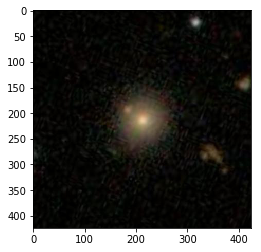

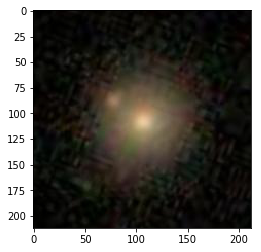

In [0]:
## Print some before/after processing images

#process_images([fetcher.train_path + '/' + fetcher.training_images_paths[100]])
im = plt.imread(fetcher.train_path + '/' + fetcher.training_images_paths[0])
# print(im.shape)

plt.imshow(im)
plt.show()
im = im[106:106*3,106:106*3,:] #crop 424x424 -> 212x212

plt.imshow(im)

In [0]:
# Create generator that yields (current features X, current labels y)
def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            X_train = augment_images(X_train)
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            y_train = np.concatenate((y_train,y_train,y_train))
            yield (X_train, y_train)
            
def ValBatchGenerator(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_train = process_images([getter.val_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
                        

### Train model

In [0]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
history = LossHistory()

if(not os.path.isdir('/kaggle/working/tmp')):
    os.mkdir('/kaggle/working/tmp')

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)


batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.
        
        
#model = load_model('tmp/weights.hdf5')

hist = model.fit_generator(BatchGenerator(fetcher),
                    steps_per_epoch=steps_to_take, 
                    epochs=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                    validation_data=ValBatchGenerator(fetcher), 
                    validation_steps=val_steps_to_take
                   )

Epoch 1/50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


 - 76s - loss: 0.0299 - val_loss: 0.0223

Epoch 00001: val_loss improved from inf to 0.02229, saving model to tmp/weights.hdf5
Epoch 2/50
 - 71s - loss: 0.0227 - val_loss: 0.0217

Epoch 00002: val_loss improved from 0.02229 to 0.02166, saving model to tmp/weights.hdf5
Epoch 3/50
 - 71s - loss: 0.0209 - val_loss: 0.0191

Epoch 00003: val_loss improved from 0.02166 to 0.01909, saving model to tmp/weights.hdf5
Epoch 4/50
 - 75s - loss: 0.0200 - val_loss: 0.0206

Epoch 00004: val_loss did not improve from 0.01909
Epoch 5/50
 - 71s - loss: 0.0193 - val_loss: 0.0165

Epoch 00005: val_loss improved from 0.01909 to 0.01653, saving model to tmp/weights.hdf5
Epoch 6/50
 - 76s - loss: 0.0185 - val_loss: 0.0164

Epoch 00006: val_loss improved from 0.01653 to 0.01643, saving model to tmp/weights.hdf5
Epoch 7/50
 - 74s - loss: 0.0181 - val_loss: 0.0169

Epoch 00007: val_loss did not improve from 0.01643
Epoch 8/50
 - 71s - loss: 0.0168 - val_loss: 0.0174

Epoch 00008: val_loss did not improve from 0

### Plot training/validation loss

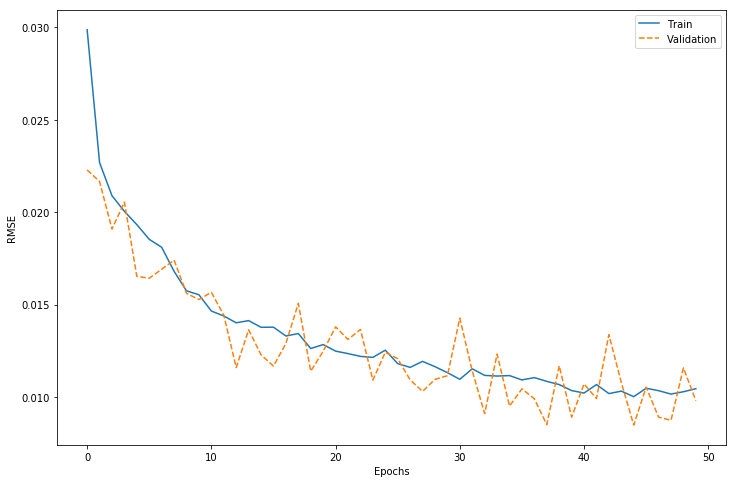

In [0]:
plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],label='Train')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Model Predict

In [0]:
# Load best model weights
from keras.models import load_model
model = load_model('/kaggle/working/tmp/weights.hdf5')

In [0]:
def TestBatchGenerator(getter):
    while 1:
        for f in getter.test_images_paths:
            X_train = process_images([getter.test_path + '/' + fname for fname in [f]])
            yield (X_train)

predictions = model.predict_generator(TestBatchGenerator(fetcher),
                       val_samples = len(fetcher.test_images_paths),
                        max_q_size = 32,)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<generator..., steps=600, max_queue_size=32)`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


In [0]:
predictions.shape

(600, 37)

In [0]:
# Clear out the working directory before saving the output file

folder = '/kaggle/working/training/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

folder = '/kaggle/working/validation/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
        
os.rmdir('/kaggle/working/training/')
os.rmdir('/kaggle/working/validation/')

In [0]:
print(os.listdir('/kaggle/working')) #checking that training and validation folders were removed

['__notebook__.ipynb', 'tmp', '__output__.json']


### Saving Output File

In [0]:
header = open('../input/all_zeros_benchmark/all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_2.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(fetcher.test_images_paths)):
        id_ = (fetcher.get_id(fetcher.test_images_paths[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")

In [0]:
print(os.listdir('/kaggle/working')) # checking that outfile was added

['__notebook__.ipynb', 'submission_2.csv', 'tmp', '__output__.json']
